In [ ]:
import sys
PATH_TO_PROJECT = "/home/tanawatp/Documents/Hexapod/PhysicalAI_modelling"
sys.path.append(PATH_TO_PROJECT)
from UtilsFunction.UtilsFunc import*
from UtilsFunction.KinematicsFunc import*
from pydrake.trajectories import PiecewisePolynomial
import matplotlib.pyplot as plt

In [2]:
def InitTrajectories(p_start, p_final, v_start, v_final, total_time):
    time = np.array([0.0, total_time])
    trajs = []
    for i in range(len(p_start)):
        P = np.array([[p_start[i],p_final[i]]])
        V = np.array([[v_start[i],v_final[i]]])
        trajs.append(PiecewisePolynomial.CubicHermite(time, P, V))
    return trajs

In [ ]:
desired_base_height = 0.1
desired_leg_lenght = 0.35

### Base  Trajectory

In [3]:
avg_x_d = 0.15 # m/s
step_length = 0.2
step_time = np.ceil(step_length*100 / avg_x_d)*0.01
p_start = np.array([0, 0, 0])
v_start = np.array([0, 0, 0])
p_final = np.array([step_length, 0, 0])
v_final = np.array([0, 0, 0])
base_traj = InitTrajectories(p_start, p_final, v_start, v_final, step_time)
base_traj_x = base_traj[0]
curr_t = 0.0
dt = 0.01
p = []
v = []
timestamp = []
while curr_t <= step_time:
    p.append(base_traj_x.value(curr_t)[0][0])
    v.append(base_traj_x.EvalDerivative(curr_t, 1)[0][0])
    timestamp.append(curr_t)
    curr_t+=dt


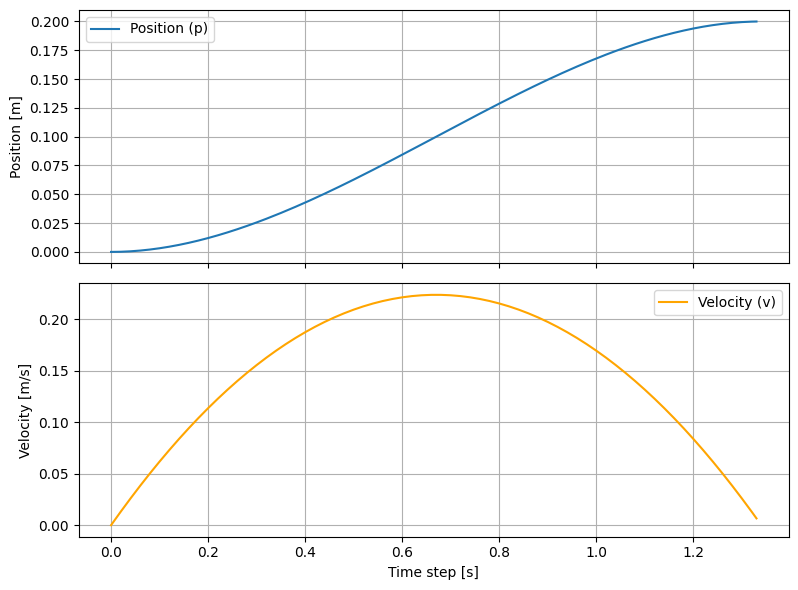

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

axs[0].plot(timestamp,p, label='Position (p)')
axs[0].set_ylabel('Position [m]')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(timestamp,v, label='Velocity (v)', color='orange')
axs[1].set_xlabel('Time step [s]')
axs[1].set_ylabel('Velocity [m/s]')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()